In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Home Team Win -> Win = 1
## Away Team Win -> Win = 0

In [36]:
# Read in the dataframe.
df_11_12 = pd.read_csv('data/benj_data/play_by_play_2011_12.csv.gz', encoding='latin1')
# df_11_12.head()

C:\Users\benja\AppData\Local\Temp\ipykernel_5576\3728607930.py:2: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_11_12 = pd.read_csv('data/benj_data/play_by_play_2011_12.csv.gz', encoding='latin1')


In [37]:
def get_data(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])

    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID'])

    # Create dictionaries to store event counts for home and away teams
    home_dict = {event: 0 for event in event_types}
    away_dict = {event: 0 for event in event_types}

    # Create DataFrames to store event data for home and away teams
    home_df = pd.DataFrame(columns=home_dict.keys())
    away_df = pd.DataFrame(columns=away_dict.keys())

    # Iterate through the events in the game and count them
    for _, row in game1.iterrows():
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(row['event_team_type']) or row['event_type'] == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if row['event_team_type'] == 'home':
            home_dict[row['event_type']] += 1
            home_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            home_dict['HOME'] = 1
            home_dict['WIN'] = 1 if row['home_final'] > row['away_final'] else 0
            home_dict['TEAM'] = row['team_encoded']
            home_dict['GAME_ID'] = game_id
            home_df = pd.concat([home_df, pd.DataFrame([home_dict])], ignore_index=True)
        else:
            away_dict[row['event_type']] += 1
            away_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            away_dict['HOME'] = 0
            away_dict['WIN'] = 1 if row['home_final'] < row['away_final'] else 0
            away_dict['TEAM'] = row['team_encoded']
            away_dict['GAME_ID'] = game_id
            away_df = pd.concat([away_df, pd.DataFrame([away_dict])], ignore_index=True)
        
    return home_df, away_df

def get_label_encoder(teams):
    le = LabelEncoder()
    le.fit(teams)
    return le

In [38]:
# Copy the dataframe (so we don't have to reload it)
df_copy = df_11_12.copy()

# Drop NaN's from event_team_type (drops events that are not helpful)
    # This includes things like game stats, end of periods, etc.
df_copy = df_copy.dropna(subset=['event_team'])

# Get all of the unique game ids, thus getting all of the games
unique_game_ids = df_11_12.game_id.unique()

# Get the label encoder for the teams
team_names = np.sort(df_copy.event_team.dropna().unique())  # Sort first to make sure the encoding is consistent
label_encoder = get_label_encoder(team_names)               # Get the label encoder (helper function)

# Label encode the teams
df_copy['team_encoded'] = label_encoder.transform(df_copy.event_team)

# Iterate through the games
final_df = pd.DataFrame()
for game_id in unique_game_ids:
    home_df, away_df = get_data(df_copy, game_id)
    final_df = pd.concat([final_df, home_df], ignore_index=True)
    final_df = pd.concat([final_df, away_df], ignore_index=True)

In [39]:
final_df

,FACEOFF,GIVEAWAY,SHOT,MISSED_SHOT,HIT,TAKEAWAY,BLOCKED_SHOT,PENALTY,GOAL,TIME_REMAINING,HOME,WIN,TEAM,GAME_ID
0,1,0,0,0,0,0,0,0,0,3600,1,0,1,2011020001
1,1,0,1,0,0,0,0,0,0,3553,1,0,1,2011020001
2,1,0,1,1,0,0,0,0,0,3539,1,0,1,2011020001
3,1,0,1,2,0,0,0,0,0,3526,1,0,1,2011020001
4,1,0,2,2,0,0,0,0,0,3486,1,0,1,2011020001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335299,19,16,15,10,47,1,9,9,1,77,0,0,16,2011030416
335300,19,16,15,11,47,1,9,9,1,74,0,0,16,2011030416
335301,19,16,15,11,48,1,9,9,1,67,0,0,16,2011030416
335302,19,16,16,11,48,1,9,9,1,64,0,0,16,2011030416


In [41]:
final = final_df

In [59]:
home = final[final.HOME == 1]
away = final[final.HOME == 0]

In [43]:
home

,FACEOFF,GIVEAWAY,SHOT,MISSED_SHOT,HIT,TAKEAWAY,BLOCKED_SHOT,PENALTY,GOAL,TIME_REMAINING,HOME,WIN,TEAM,GAME_ID
0,1,0,0,0,0,0,0,0,0,3600,1,0,1,2011020001
1,1,0,1,0,0,0,0,0,0,3553,1,0,1,2011020001
2,1,0,1,1,0,0,0,0,0,3539,1,0,1,2011020001
3,1,0,1,2,0,0,0,0,0,3526,1,0,1,2011020001
4,1,0,2,2,0,0,0,0,0,3486,1,0,1,2011020001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335168,33,20,19,16,34,3,16,3,6,210,1,1,12,2011030416
335169,34,20,19,16,34,3,16,3,6,210,1,1,12,2011030416
335170,34,20,19,16,34,4,16,3,6,105,1,1,12,2011030416
335171,34,20,19,16,34,5,16,3,6,42,1,1,12,2011030416


In [60]:
def merge_home_away(home_df, away_df):
     # change the names in the home_df to be HOME_[current column name] and same for away_df
     home_df.columns = ['HOME_' + col for col in home_df.columns]
     away_df.columns = ['AWAY_' + col for col in away_df.columns]
     # change TIME_REMAINING, WIN, GAME_ID to be the same in both dataframes
     home_df = home_df.rename(columns={'HOME_TIME_REMAINING': 'TIME_REMAINING', 'HOME_WIN': 'WIN', 'HOME_GAME_ID': 'GAME_ID'})
     away_df = away_df.rename(columns={'AWAY_TIME_REMAINING': 'TIME_REMAINING', 'AWAY_WIN': 'WIN', 'AWAY_GAME_ID': 'GAME_ID'})

     full = pd.merge(home_df, away_df, on=['TIME_REMAINING', 'WIN', 'GAME_ID'], how='outer')

     # # if home_df has 1 in WIN column than make all the values in the WIN column 1
     # if 1 in home_df.WIN.unique():
     #      full.WIN = 1
     # elif 1 in away_df.WIN.unique():
     #      full.WIN = 0

     full.drop(columns=['HOME_HOME', 'AWAY_HOME'])
     full = full.groupby('GAME_ID').apply(lambda x: x.sort_values(by='TIME_REMAINING')).reset_index(drop=True)
     full.fillna(method='ffill', inplace=True)
     full.fillna(0, inplace=True)

     return full

In [61]:
full = merge_home_away(home, away)

C:\Users\benja\AppData\Local\Temp\ipykernel_5576\3669769796.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full = full.groupby('GAME_ID').apply(lambda x: x.sort_values(by='TIME_REMAINING')).reset_index(drop=True)
C:\Users\benja\AppData\Local\Temp\ipykernel_5576\3669769796.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full.fillna(method='ffill', inplace=True)
C:\Users\benja\AppData\Local\Temp\ipykernel_5576\3669769796.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. 

In [62]:
# put WIN at the end
cols = list(full.columns)
cols.remove('WIN')
cols.append('WIN')

full = full[cols]
full

,HOME_FACEOFF,HOME_GIVEAWAY,HOME_SHOT,HOME_MISSED_SHOT,HOME_HIT,HOME_TAKEAWAY,HOME_BLOCKED_SHOT,HOME_PENALTY,HOME_GOAL,TIME_REMAINING,...,AWAY_SHOT,AWAY_MISSED_SHOT,AWAY_HIT,AWAY_TAKEAWAY,AWAY_BLOCKED_SHOT,AWAY_PENALTY,AWAY_GOAL,AWAY_HOME,AWAY_TEAM,WIN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,...,27,9,17,2,9,7,2,0,20,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,...,27,9,17,2,9,7,2,0,20,1
2,31.0,11.0,22.0,12.0,19.0,8.0,17.0,5.0,1.0,20,...,27,9,17,2,9,7,2,0,20,0
3,32.0,11.0,22.0,12.0,19.0,8.0,17.0,5.0,1.0,20,...,27,9,17,2,9,7,2,0,20,0
4,31.0,11.0,22.0,12.0,19.0,8.0,17.0,4.0,1.0,34,...,27,9,17,2,9,7,2,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334852,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3551,...,0,0,1,0,0,0,0,0,16,1
334853,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3556,...,0,0,1,0,0,0,0,0,16,1
334854,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3564,...,0,0,1,0,0,0,0,0,16,1
334855,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3592,...,0,0,1,0,0,0,0,0,16,0


In [47]:
full

,HOME_FACEOFF,HOME_GIVEAWAY,HOME_SHOT,HOME_MISSED_SHOT,HOME_HIT,HOME_TAKEAWAY,HOME_BLOCKED_SHOT,HOME_PENALTY,HOME_GOAL,TIME_REMAINING,...,AWAY_SHOT,AWAY_MISSED_SHOT,AWAY_HIT,AWAY_TAKEAWAY,AWAY_BLOCKED_SHOT,AWAY_PENALTY,AWAY_GOAL,AWAY_HOME,AWAY_TEAM,WIN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,...,27,9,17,2,9,7,2,0,20,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,...,27,9,17,2,9,7,2,0,20,1
2,31.0,11.0,22.0,12.0,19.0,8.0,17.0,5.0,1.0,20,...,27,9,17,2,9,7,2,0,20,1
3,32.0,11.0,22.0,12.0,19.0,8.0,17.0,5.0,1.0,20,...,27,9,17,2,9,7,2,0,20,1
4,31.0,11.0,22.0,12.0,19.0,8.0,17.0,4.0,1.0,34,...,27,9,17,2,9,7,2,0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334852,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3551,...,0,0,1,0,0,0,0,0,16,1
334853,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3556,...,0,0,1,0,0,0,0,0,16,1
334854,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3564,...,0,0,1,0,0,0,0,0,16,1
334855,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3592,...,0,0,1,0,0,0,0,0,16,1


In [49]:
#print unique GAME_IDs
full.GAME_ID.unique()

array([2011020001, 2011020002, 2011020003, ..., 2011030414, 2011030415,
       2011030416], dtype=int64)

In [63]:
full.WIN.unique()

array([1, 0], dtype=int64)

In [65]:
# Load your dataset (assuming df is your DataFrame)
df = full

# Define X and y (features and target)
X = df.drop(['WIN', 'GAME_ID'], axis=1)  # Assuming 'WIN' is the target variable
y = df['WIN']  # Keep y as a pandas Series

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Extract data for a certain timestep from your dataset
game_id = 2011030416  # Specify the game ID
desired_timestep = 1500  # Specify the desired timestep
game_data = df[df['GAME_ID'] == game_id]
timestep_data = game_data[game_data['TIME_REMAINING'] < desired_timestep]

# Prepare the timestep data for prediction
X_timestep = timestep_data.drop(['WIN', 'GAME_ID'], axis=1)

# Predict the outcome for the timestep
outcome = model.predict(X_timestep)
probabilities = model.predict_proba(X_timestep)

# Print the predicted outcome and probabilities
print("Predicted outcome:", outcome)
print("Probabilities:", probabilities)

Predicted outcome: [0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0
 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Probabilities: [[0.95159423 0.04840576]
 [0.37648892 0.6235111 ]
 [0.5104995  0.48950055]
 [0.5819427  0.41805732]
 [0.5819427  0.41805732]
 [0.5819427  0.41805732]
 [0.5856394  0.41436058]
 [0.5856394  0.41436058]
 [0.4103666  0.5896334 ]
 [0.4103666  0.5896334 ]
 [0.41503638 0.5849636 ]
 [0.41503638 0.5849636 ]
 [0.50276923 0.4972308 ]
 [0.50276923 0.4972308 ]
 [0.50276923 0.4972308 ]
 [0.58221006 0.41778994]
 [0.65894186 0.3410581 ]
 [0.7439363  0.2560637 ]
 [0.7439363  0.2560637 ]
 [0.6487019  0.3512981 ]
 [0.66642046 0.33357957]
 [0.75426435 0.24573565]
 [0.75426435 0.24573565]
 [0.6325007  0.3674993 ]
 [0.58512706 0.41487294]
 [0.54019105 0.45980898]
 [0.54019105 0.45980898]
 [0.5286702  0.47132984]
 [0.48665106 0.51334894]
 [0.48665106 0.51334894]


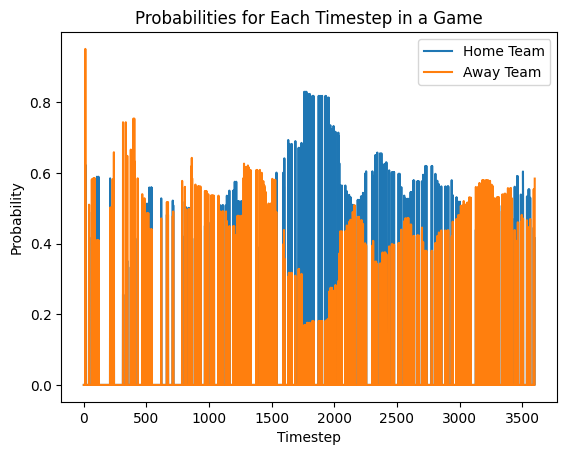

In [67]:
# Load your dataset (assuming df is your DataFrame)
df = full

# Specify the game ID
game_id = 2011030416

# Extract data for the specified game
game_data = df[df['GAME_ID'] == game_id]

# Initialize lists to store probabilities for each timestep
probabilities_home = []
probabilities_away = []

# Loop through each timestep in the game data
for timestep in range(game_data['TIME_REMAINING'].max() + 1):
    # Extract data for the current timestep
    timestep_data = game_data[game_data['TIME_REMAINING'] == timestep]
    
    # Check if timestep data is available
    if not timestep_data.empty:
        X_timestep = timestep_data.drop(['WIN', 'GAME_ID'], axis=1)
        
        # Predict the probabilities for the current timestep
        probabilities = model.predict_proba(X_timestep)
        
        # Append the probabilities for home and away teams
        probabilities_home.append(probabilities[0][1])  # Probability for home team winning
        probabilities_away.append(probabilities[0][0])  # Probability for away team winning
    else:
        probabilities_home.append(0)  # Assume 0 probability if no data available
        probabilities_away.append(0)  # Assume 0 probability if no data available

# Plot the probabilities for each timestep
plt.plot(range(len(probabilities_home)), probabilities_home, label='Home Team')
plt.plot(range(len(probabilities_away)), probabilities_away, label='Away Team')
plt.xlabel('Timestep')
plt.ylabel('Probability')
plt.title('Probabilities for Each Timestep in a Game')
plt.legend()
plt.show()